## Credit Card Fraud Detection Project

In [1]:
# Import the necessary modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score

In [2]:
# Load the csv file

df = pd.read_csv("./creditcard.csv")


In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Perform Exploratory Data Analysis

In [4]:
df.shape

(284807, 31)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# Check for null values

df.isnull().values.any()

False

In [7]:
#The feature we are most interested in is the Amount


df["Amount"].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [8]:
# checking the number of occurrences of each class label
non_fraud = len(df[df.Class == 0])
fraud = len(df[df.Class == 1])
fraud_percent = (fraud / (fraud + non_fraud)) * 100

print("Number of Genuine transactions: ", non_fraud)
print("Number of Fraud transactions: ", fraud)
print("Percentage of Fraud transactions: {:.4f}".format(fraud_percent))

Number of Genuine transactions:  284315
Number of Fraud transactions:  492
Percentage of Fraud transactions: 0.1727


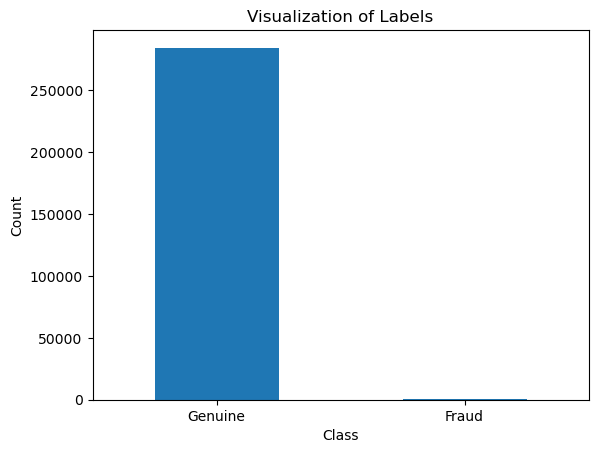

In [9]:
# Visualizing the "Labels" column in our dataset

labels = ["Genuine", "Fraud"]
count_classes = df.value_counts(df['Class'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

In [10]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [11]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
print("Frauds: ",frauds.shape)
print("Normal: ",normal.shape)

Frauds:  (492, 31)
Normal:  (284315, 31)


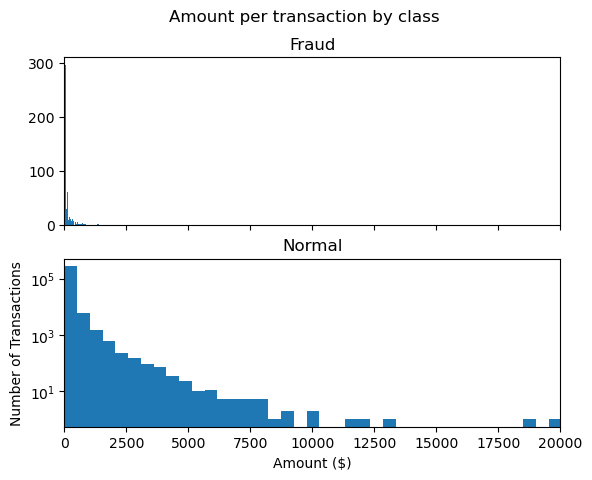

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

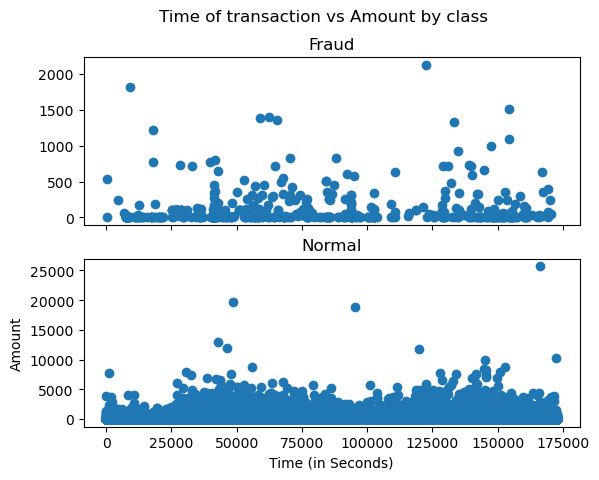

In [13]:
# Plotting time of transaction to check for correlations

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()


The time does not seem to be a crucial feature in distinguishing normal vs fraud cases. Hence, I will drop it.



The Amount feature to transform the range of values. We drop the original Amount column and add a new column with the scaled values. We also drop the Time column as it is irrelevant.

In [14]:
df_norm = df.copy()

In [15]:
# Perform Scaling
scaler = StandardScaler()
df_norm["NormalizedAmount"] = scaler.fit_transform(df["Amount"].values.reshape(-1, 1))
df_norm.drop(["Amount", "Time"], inplace= True, axis= 1)

In [16]:
df_norm

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,NormalizedAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.350151
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,-0.254117
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,-0.081839
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.313249


In [17]:
X = df_norm.drop(["Class"], axis= 1)
Y = df_norm["Class"]

In [18]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [19]:
# Split the data
(train_X, test_X, train_Y, test_Y) = train_test_split(X, Y, test_size= 0.3, random_state= 42)

print("Shape of train_X: ", train_X.shape)
print("Shape of test_X: ", test_X.shape)

Shape of train_X:  (199364, 29)
Shape of test_X:  (85443, 29)


Let's train different models on our dataset and observe which algorithm works better for our problem.

Let's apply Random Forests and Decision Trees algorithms to our dataset.

Also we will apply AutoEncoder Deep Learning model with Logistic Regression Algorithm

In [20]:
# Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(train_X, train_Y)

predictions_dt = decision_tree.predict(test_X)
decision_tree_score = decision_tree.score(test_X, test_Y) * 100

In [21]:
print("Decision Tree Score: ", decision_tree_score)

Decision Tree Score:  99.92392589211521


In [22]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators= 100, random_state=0)
random_forest.fit(train_X, train_Y)

predictions_rf = random_forest.predict(test_X)
random_forest_score = random_forest.score(test_X, test_Y) * 100

In [23]:
print("Random Forest Score: ", random_forest_score)

Random Forest Score:  99.96254813150287


In [24]:
# The below function is directly taken from the scikit-learn website to plot the confusion matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



In [25]:
# Plot confusion matrix for Decision Trees

confusion_matrix_dt = confusion_matrix(test_Y, predictions_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt)

Confusion Matrix - Decision Tree
[[85264    43]
 [   22   114]]


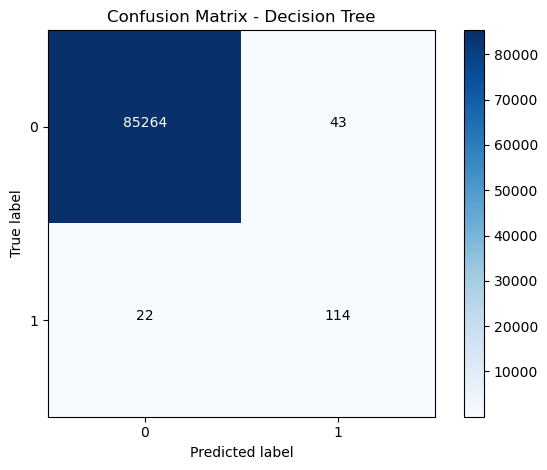

In [26]:
plot_confusion_matrix(confusion_matrix_dt, classes=[0, 1], title= "Confusion Matrix - Decision Tree")

In [27]:
# Plot confusion matrix for Random Forests

confusion_matrix_rf = confusion_matrix(test_Y, predictions_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)

Confusion Matrix - Random Forest
[[85301     6]
 [   26   110]]


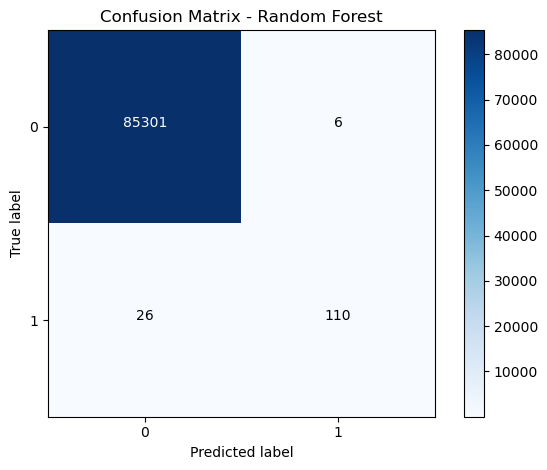

In [28]:
plot_confusion_matrix(confusion_matrix_rf, classes=[0, 1], title= "Confusion Matrix - Random Forest")

In [29]:
# The below function prints the following necesary metrics

def metrics(actuals, predictions):
    print("Accuracy: {:.5f}".format(accuracy_score(actuals, predictions)))
    print("Precision: {:.5f}".format(precision_score(actuals, predictions)))
    print("Recall: {:.5f}".format(recall_score(actuals, predictions)))
    print("F1-score: {:.5f}".format(f1_score(actuals, predictions)))
    

In [30]:
# Decision Tree
print("Evaluation of Decision Tree Model")
print()
metrics(test_Y, predictions_dt.round())

Evaluation of Decision Tree Model

Accuracy: 0.99924
Precision: 0.72611
Recall: 0.83824
F1-score: 0.77816


In [31]:
# Random Forest
print("Evaluation of Random Forest Model")
print()
metrics(test_Y, predictions_rf.round())

Evaluation of Random Forest Model

Accuracy: 0.99963
Precision: 0.94828
Recall: 0.80882
F1-score: 0.87302


### DNN Model

In [43]:

from keras.layers import Activation, Dense, Dropout


In [44]:
model = Sequential([
Dense(input_dim = 29, units = 16, activation = 'relu'),
Dense(units = 24, activation = 'relu'),
Dropout(0.5),
Dense(units = 20, activation = 'relu'),
Dense(units = 24, activation = 'relu'),
Dense(units =1, activation = 'sigmoid'),])

In [45]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(train_X, train_Y, batch_size = 15, epochs = 5)

Epoch 1/5
13291/13291 [==============================] - 36s 3ms/step - loss: 0.0090 - accuracy: 0.9988
Epoch 2/5
13291/13291 [==============================] - 35s 3ms/step - loss: 0.0042 - accuracy: 0.9993
Epoch 3/5
13291/13291 [==============================] - 33s 2ms/step - loss: 0.0041 - accuracy: 0.9993
Epoch 4/5
13291/13291 [==============================] - 33s 3ms/step - loss: 0.0038 - accuracy: 0.9993
Epoch 5/5
13291/13291 [==============================] - 35s 3ms/step - loss: 0.0036 - accuracy: 0.9994


In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                480       
                                                                 
 dense_3 (Dense)             (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_4 (Dense)             (None, 20)                500       
                                                                 
 dense_5 (Dense)             (None, 24)                504       
                                                                 
 dense_6 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,917
Trainable params: 1,917
Non-trainabl

In [47]:
score = model.evaluate(test_X, test_Y)

2671/2671 [==============================] - 6s 2ms/step - loss: 0.0032 - accuracy: 0.9994


In [48]:
print(score)

[0.0031831366941332817, 0.999426543712616]


In [49]:
predict_dnn = model.predict(test_X)

2671/2671 [==============================] - 4s 1ms/step


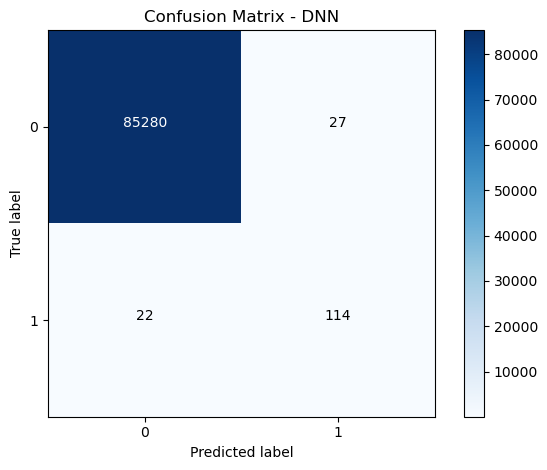

In [50]:
dnn_cm = confusion_matrix(test_Y, predict_dnn.round())
plot_confusion_matrix(dnn_cm, classes=[0, 1], title= "Confusion Matrix - DNN")

In [51]:
metrics(test_Y, predict_dnn.round())

Accuracy: 0.99943
Precision: 0.80851
Recall: 0.83824
F1-score: 0.82310


But, if we clearly observe our dataset suffers a serious problem of **class imbalance**. 
The genuine (not fraud) transactions are more than 99% with the fraud transactions constituting of 0.17%.

With such kind of distribution, if we train our model without taking care of the imbalance issues, it predicts the label with higher importance given to genuine transactions (as there are more data about them) and hence obtains more accuracy.

The class imbalance problem can be solved by various techniques. **Over sampling** is one of them.
 
One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. 

Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the **Synthetic Minority Oversampling Technique**, or **SMOTE** for short.

In [52]:
# Performing oversampling on RF and DT

from imblearn.over_sampling import SMOTE

X_resampled, Y_resampled = SMOTE().fit_resample(X, Y)
print("Resampled shape of X: ", X_resampled.shape)
print("Resampled shape of Y: ", Y_resampled.shape)

value_counts = Counter(Y_resampled)
print(value_counts)

(X_train, X_test, Y_train, Y_test) = train_test_split(X_resampled, Y_resampled, test_size= 0.3, random_state= 42)

Resampled shape of X:  (568630, 29)
Resampled shape of Y:  (568630,)
Counter({0: 284315, 1: 284315})


### Random Forest classifier


In [53]:

rf_resampled = RandomForestClassifier(n_estimators = 100, random_state=0)
rf_resampled.fit(X_train, Y_train)

predictions_resampled = rf_resampled.predict(X_test)
random_forest_score_resampled = rf_resampled.score(X_test, Y_test) * 100

In [54]:
# Visualize the confusion matrix

rf_cm_resampled = confusion_matrix(Y_test, predictions_resampled.round())
print("Confusion Matrix - Random Forest")
print(rf_cm_resampled)

Confusion Matrix - Random Forest
[[85127    22]
 [    0 85440]]


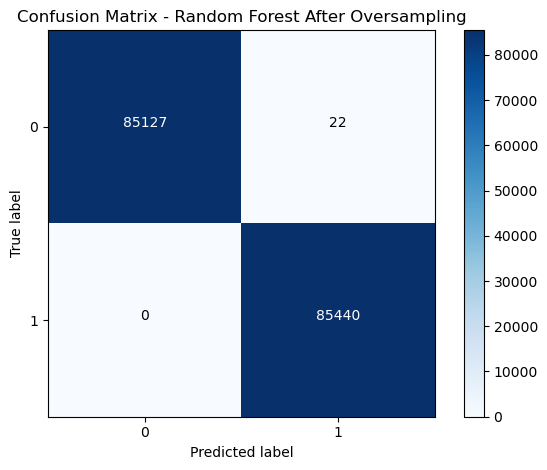

In [56]:
plot_confusion_matrix(rf_cm_resampled, classes=[0, 1], title= "Confusion Matrix - Random Forest After Oversampling")

In [57]:
print("Evaluation of Random Forest Model")
metrics(Y_test, predictions_resampled.round())

Evaluation of Random Forest Model
Accuracy: 0.99987
Precision: 0.99974
Recall: 1.00000
F1-score: 0.99987


### Decision Tree Classifier


In [58]:
dt_resampled = DecisionTreeClassifier(random_state=0)
dt_resampled.fit(X_train, Y_train)

dt_pred_resample = dt_resampled.predict(X_test)
dt_resample_score = dt_resampled.score(X_test, Y_test) * 100

In [59]:
# Visualize the confusion matrix

dt_cm_resampled = confusion_matrix(Y_test, dt_pred_resample.round())
print("Confusion Matrix - Decison Tree")
print(dt_cm_resampled)

Confusion Matrix - Decison Tree
[[84924   225]
 [   96 85344]]


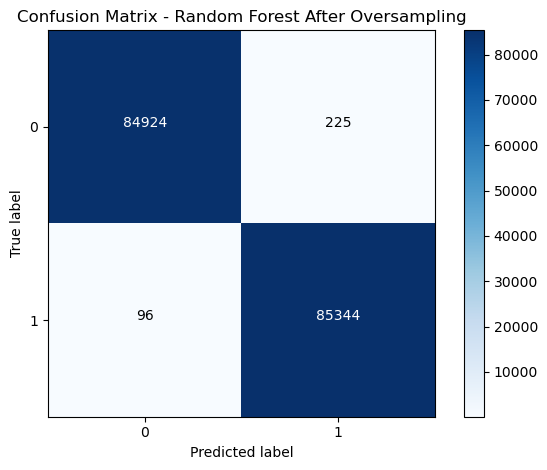

In [60]:
plot_confusion_matrix(dt_cm_resampled, classes=[0, 1], title= "Confusion Matrix - Random Forest After Oversampling")

In [61]:
print("Evaluation of Decision tree Model")
metrics(Y_test, dt_pred_resample.round())

Evaluation of Decision tree Model
Accuracy: 0.99812
Precision: 0.99737
Recall: 0.99888
F1-score: 0.99812


In [62]:
from keras.models import Sequential


### DNN model

Build a 5-layer deep neural networking using the Sequential model in Keras.

In [63]:
model = Sequential([
Dense(input_dim = 29, units = 16, activation = 'relu'),
Dense(units = 24, activation = 'relu'),
Dropout(0.5),
Dense(units = 20, activation = 'relu'),
Dense(units = 24, activation = 'relu'),
Dense(units =1, activation = 'sigmoid'),])

In [64]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, Y_train, batch_size = 15, epochs = 5)

Epoch 1/5
26537/26537 [==============================] - 69s 3ms/step - loss: 0.0432 - accuracy: 0.9846
Epoch 2/5
26537/26537 [==============================] - 67s 3ms/step - loss: 0.0181 - accuracy: 0.9950
Epoch 3/5
26537/26537 [==============================] - 68s 3ms/step - loss: 0.0137 - accuracy: 0.9964
Epoch 4/5
26537/26537 [==============================] - 69s 3ms/step - loss: 0.0118 - accuracy: 0.9972
Epoch 5/5
26537/26537 [==============================] - 73s 3ms/step - loss: 0.0108 - accuracy: 0.9973


In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 16)                480       
                                                                 
 dense_8 (Dense)             (None, 24)                408       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                500       
                                                                 
 dense_10 (Dense)            (None, 24)                504       
                                                                 
 dense_11 (Dense)            (None, 1)                 25        
                                                                 
Total params: 1,917
Trainable params: 1,917
Non-traina

In [66]:
score = model.evaluate(X_test, Y_test)

5331/5331 [==============================] - 12s 2ms/step - loss: 0.0083 - accuracy: 0.9982


In [67]:
print(score)

[0.008345977403223515, 0.9981769323348999]


In [68]:
predict_dnn = model.predict(X_test)

5331/5331 [==============================] - 9s 2ms/step


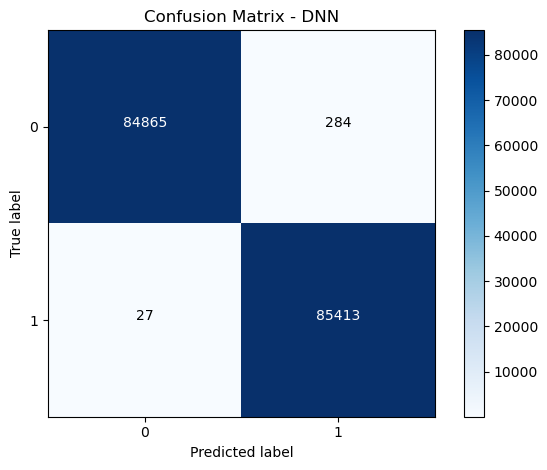

In [69]:
dnn_cm = confusion_matrix(Y_test, predict_dnn.round())
plot_confusion_matrix(dnn_cm, classes=[0, 1], title= "Confusion Matrix - DNN")

In [70]:
metrics(Y_test, predict_dnn.round())

Accuracy: 0.99818
Precision: 0.99669
Recall: 0.99968
F1-score: 0.99818


In [71]:
print("Decision Tree Model Metrics")
metrics(Y_test, dt_pred_resample.round())
print("_____________________________________________________")
print("Random Forest Model Metrics")
metrics(Y_test, predictions_resampled.round())
print("_____________________________________________________")
print("DNN Model Metrics")
metrics(Y_test, predict_dnn.round())


Decision Tree Model Metrics
Accuracy: 0.99812
Precision: 0.99737
Recall: 0.99888
F1-score: 0.99812
_____________________________________________________
Random Forest Model Metrics
Accuracy: 0.99987
Precision: 0.99974
Recall: 1.00000
F1-score: 0.99987
_____________________________________________________
DNN Model Metrics
Accuracy: 0.99818
Precision: 0.99669
Recall: 0.99968
F1-score: 0.99818


Now it is evident that after addressing the class imbalance problem, our models with SMOTE performs far better than the models without SMOTE

In [72]:
import pickle

In [75]:
with open("model.pkl", "wb") as f:
    pickle.dump(rf_resampled, f)